In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import desc

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

C:\Users\excep\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


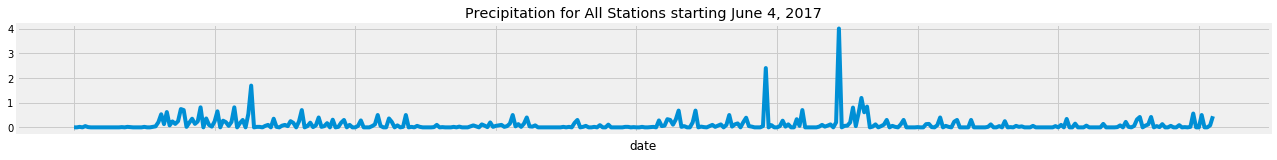

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
conn = engine.connect()
# Perform a query to retrieve the data and precipitation scores
data_table = pd.read_sql("select * from Measurement where date>'2017-06-04' order by date",conn)
# Convert the result to a Pandas Dataframe with only date and precipitation amounts
measurement_df = pd.DataFrame(data_table)
date_prcp= measurement_df[['date','prcp']]
# Set date field as the index
date_prcp.set_index("date",inplace=True)
# Drop all records where there is no data for precipiation (prcp=NaN)
date_prcp.dropna(subset=['prcp'], inplace = True)
# Sort the dataframe by date
date_prcp.sort_values(by='date')
# Use Pandas Plotting with Matplotlib to plot the data
date_prcp.plot(legend=False, title="Precipitation for All Stations starting June 4, 2017", figsize=(20,2))
# Why don't I have tick marks/dates?
# Rotate the xticks for the dates
# plt.xticks(rotation='vertical')

In [44]:
# Use Pandas to calculate the summary statistics for the precipitation data
date_prcp.describe()

,prcp
count,406.000000
mean,0.116453
std,0.294177
min,0.000000
25%,0.000000
50%,0.020000
75%,0.117500
max,4.000000


In [45]:
# How many stations are available in this dataset?
stations = measurement_df.groupby('station').max()
len(stations)

7

In [24]:
# What are the most active stations?
# List the stations and the counts in descending order.
stn_list = measurement_df['station'].value_counts()
print(stn_list)

USC00516128    78
USC00519397    77
USC00519523    72
USC00514830    66
USC00519281    66
USC00513117    57
USC00517948    36
Name: station, dtype: int64


In [25]:
# Which station has the highest number of observations?
top_obs = stn_list.head(1).index.tolist()
print(top_obs)

['USC00516128']


In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_data = pd.read_sql("select station, tobs from Measurement where date>'2017-06-04' and station='USC00516128'",conn)
temp_stats = temp_data.groupby(['station']).agg({'tobs':['min','max','mean']})
print(temp_stats)

             tobs                 
              min   max       mean
station                           
USC00516128  70.0  80.0  75.128205


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000289E5442470>]],
      dtype=object)

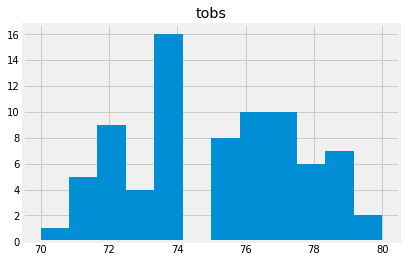

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = pd.read_sql("select tobs from Measurement where date>'2017-06-04' and station='USC00516128'",conn)
temp_data.hist(bins=12)

In [28]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2016-10-01','2016-10-14')
print(my_trip)

[(71.0, 77.79775280898876, 82.0)]


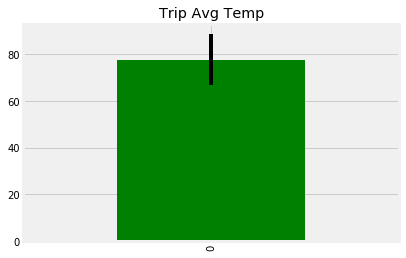

In [30]:
# Convert the results from your previous query into a Pandas DataFrame
my_trip_df = pd.DataFrame(my_trip,columns=['tmin', 'tavg', 'tmax'])
# Plot as a bar chart, using "Trip Avg Temp" as your Title:
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr_bar=my_trip_df['tmin']-my_trip_df['tmax']
# Use the average temperature for the y value
my_trip_df.plot.bar(x=None,y='tavg',legend=False,yerr=yerr_bar,title=f"Trip Avg Temp",colormap='ocean')

In [69]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Perform a query to retrieve the data and precipitation info
data_table = pd.read_sql("select * from Measurement where date>='2016-10-01' AND date<='2016-10-14'",conn)
measurement_df = pd.DataFrame(data_table)
prcp_data_by_stn = measurement_df[['station','prcp']]
# Groupby average precipiation per station
stn_prcp = prcp_data_by_stn.groupby(['station']).mean()
# Perform a query to retrieve general station information from Stations
stn_table = pd.read_sql("select * from Station",conn)
# Join the two dataframes
stn_info = stn_prcp.merge(how='left',on='station',right=stn_table)
# Set station field as index
stn_info = stn_info.set_index('station')
# Remove unneeded id column
stn_info = stn_info.drop(columns='id')
# Sort values in descending order by average precipiation
stn_info = stn_info.sort_values('prcp',ascending=False)

print(stn_info)

                 prcp                                    name  latitude  \
station                                                                   
USC00516128  0.491429            MANOA LYON ARBO 785.2, HI US  21.33310   
USC00517948  0.070000                       PEARL CITY, HI US  21.39340   
USC00519281  0.050714                     WAIHEE 837.5, HI US  21.45167   
USC00513117  0.021429                    KANEOHE 838.1, HI US  21.42340   
USC00514830  0.018182  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130   
USC00519523  0.005000      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556   
USC00519397  0.000000                    WAIKIKI 717.2, HI US  21.27160   

             longitude  elevation  
station                            
USC00516128 -157.80250      152.4  
USC00517948 -157.97510       11.9  
USC00519281 -157.84889       32.9  
USC00513117 -157.80150       14.6  
USC00514830 -157.83740        7.0  
USC00519523 -157.71139       19.5  
USC00519397 -157.81680        3.0  
